In [1]:
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
from collections import deque
import matplotlib.pyplot as plt

%matplotlib inline

import tensorflow as tf
from keras.layers import *
from keras.models import Sequential, load_model
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.utils import plot_model

from sklearn.model_selection import train_test_split

In [2]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

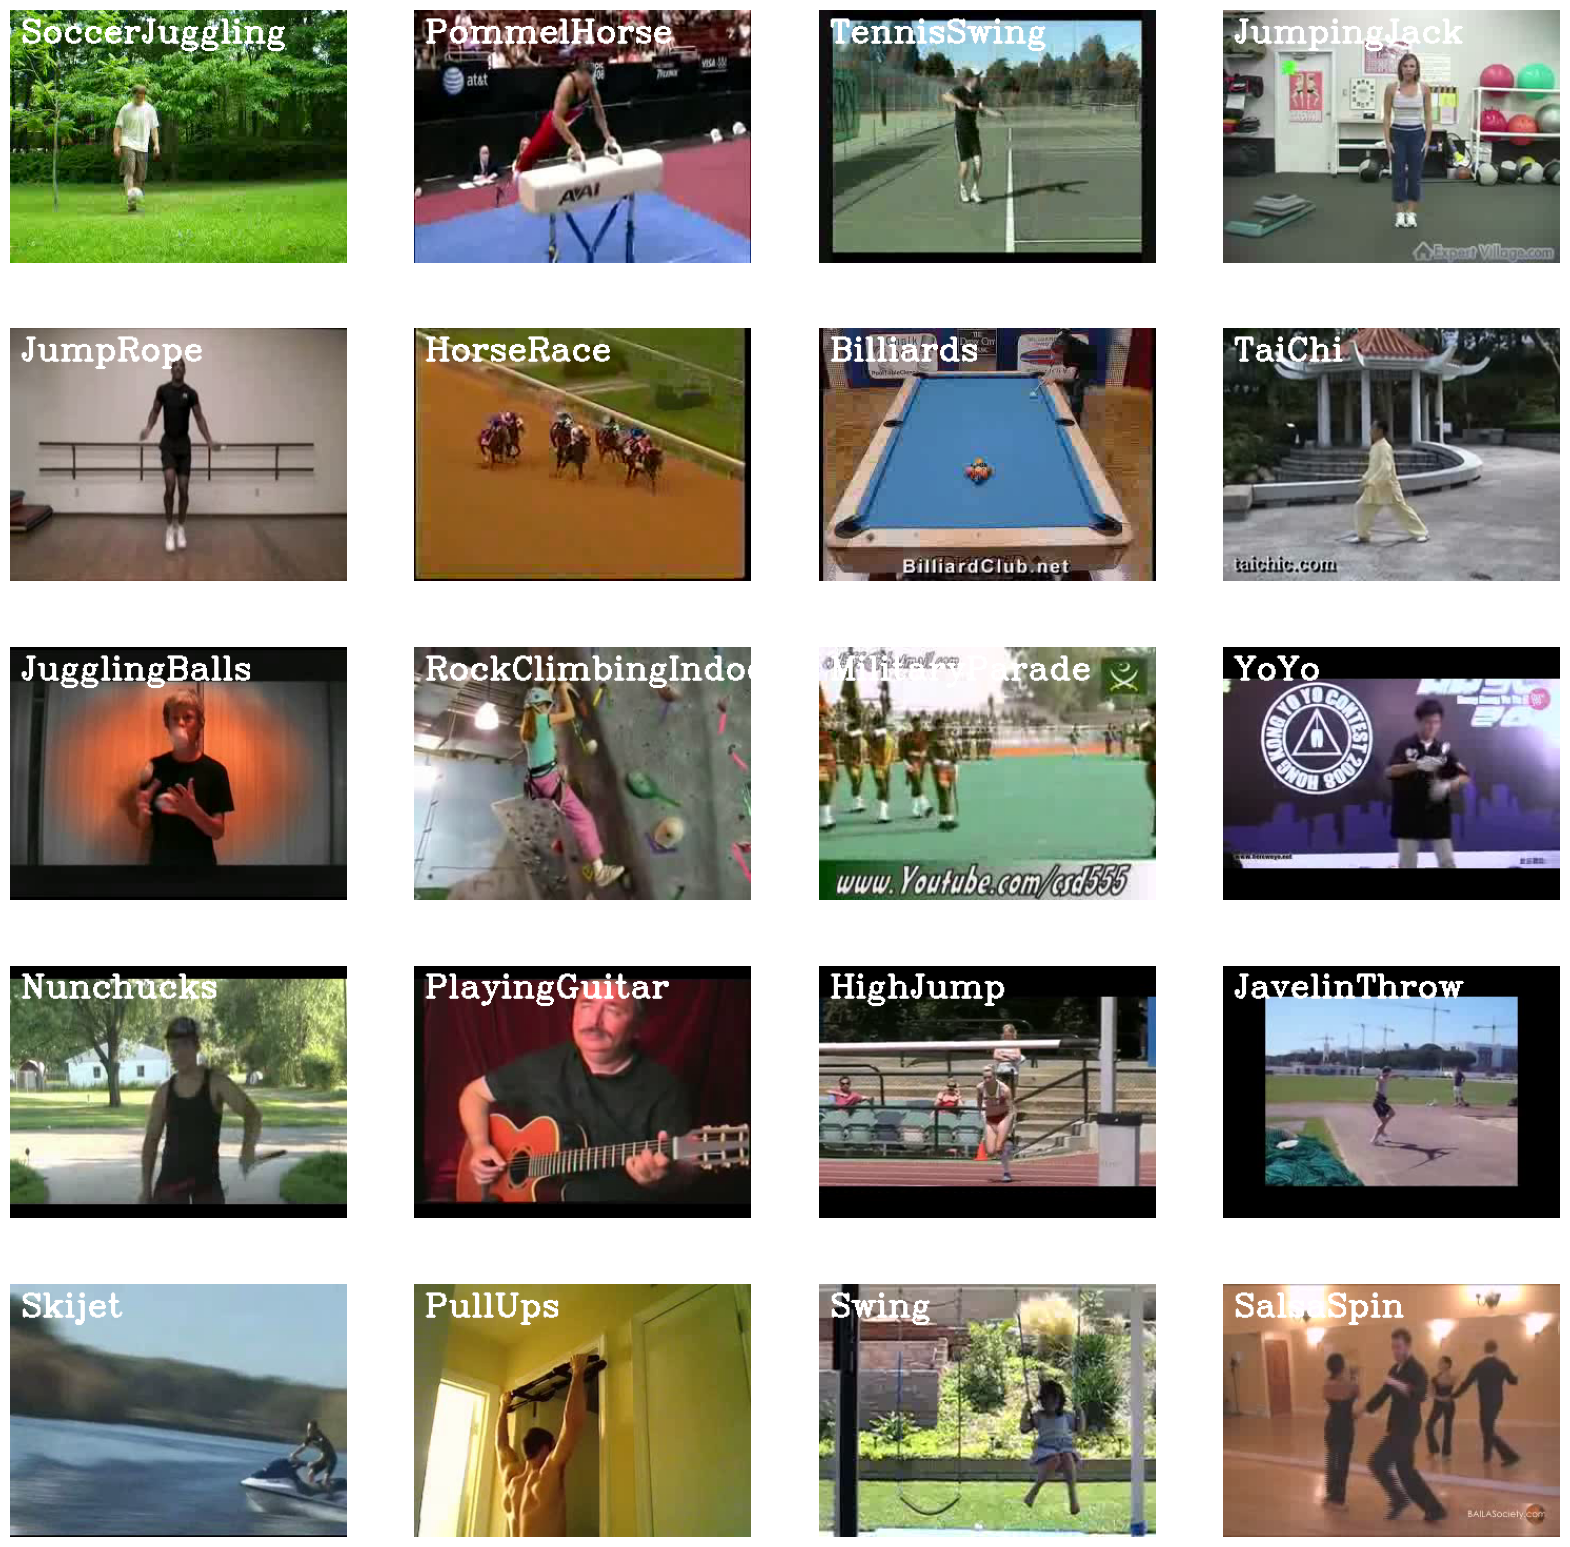

In [3]:
plt.figure(figsize=(20, 20))

# Get class name
all_class_names = os.listdir('UCF50')

# Generate list of 20 random activities
random_range = random.sample(range(len(all_class_names)), 20)
for counter, random_index in enumerate(random_range, 1):
    selected_class_name = all_class_names[random_index]
    video_files_name_list = os.listdir(f'UCF50/{selected_class_name}')
    selected_video_file_name = random.choice(video_files_name_list)
    
    # Visualize
    cap = cv2.VideoCapture(f'UCF50/{selected_class_name}/{selected_video_file_name}')
    _, frame = cap.read()
    cap.release()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    cv2.putText(frame, selected_class_name, (10,30), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255), 2)
    
    # Display frame
    plt.subplot(5, 4, counter)
    plt.imshow(frame)
    plt.axis('off')

In [4]:
all_class_names

['BaseballPitch',
 'Basketball',
 'BenchPress',
 'Biking',
 'Billiards',
 'BreastStroke',
 'CleanAndJerk',
 'Diving',
 'Drumming',
 'Fencing',
 'GolfSwing',
 'HighJump',
 'HorseRace',
 'HorseRiding',
 'HulaHoop',
 'JavelinThrow',
 'JugglingBalls',
 'JumpingJack',
 'JumpRope',
 'Kayaking',
 'Lunges',
 'MilitaryParade',
 'Mixing',
 'Nunchucks',
 'PizzaTossing',
 'PlayingGuitar',
 'PlayingPiano',
 'PlayingTabla',
 'PlayingViolin',
 'PoleVault',
 'PommelHorse',
 'PullUps',
 'Punch',
 'PushUps',
 'RockClimbingIndoor',
 'RopeClimbing',
 'Rowing',
 'SalsaSpin',
 'SkateBoarding',
 'Skiing',
 'Skijet',
 'SoccerJuggling',
 'Swing',
 'TaiChi',
 'TennisSwing',
 'ThrowDiscus',
 'TrampolineJumping',
 'VolleyballSpiking',
 'WalkingWithDog',
 'YoYo']

In [5]:
image_width = 64
image_height = 64

sequence_length = 20
dataset_dir = 'UCF50'
class_list = ["WalkingWithDog", "TaiChi", "Swing", "HorseRace"]

In [6]:
def frame_extraction(video_path):
    frame_list = []
    cap = cv2.VideoCapture(video_path)
    
    # Skip frame
    video_frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frame = max(int(video_frame_count / sequence_length), 1)
    
    for frame_counter in range(sequence_length):
        # Set frame position
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frame)
        success, frame = cap.read()
        if not success:
            break
        
        # Resize frame
        resized = cv2.resize(frame, (image_height, image_width))
        nomalized = resized / 255
        
        frame_list.append(nomalized)

    cap.release()
    return frame_list

In [7]:
def create_dataset():
    features = [] # Contain frames of the videos
    labels = [] # Contain indexes of class which associated with the videos
    video_file_paths = [] # Contain paths of the videos
    
    for class_index, class_name in enumerate(class_list):
        print(f'Create data of class: {class_name}')
        
        # Get list of video which nemed in class name
        file_list = os.listdir(os.path.join(dataset_dir, class_name))
        for file_name in file_list:
            # Get full video path
            video_file_path = os.path.join(dataset_dir, class_name, file_name)
            frames = frame_extraction(video_file_path)
            
            if len(frames) == sequence_length:
                features.append(frames)
                labels.append(class_index)
                video_file_paths.append(video_file_path)
    
    # Convert list to array
    features = np.asarray(features)
    labels = np.array(labels)
    
    return features, labels, video_file_paths

In [8]:
features, labels, video_file_paths = create_dataset()

Create data of class: WalkingWithDog
Create data of class: TaiChi
Create data of class: Swing
Create data of class: HorseRace


In [9]:
one_hot_encoded_labels = to_categorical(labels)

In [10]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size=0.2, shuffle=True, random_state=seed_constant)

In [11]:
def create_convlstm_model():
    model = Sequential()
    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (sequence_length, image_height, image_width, 3)))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(Flatten()) 
    
    model.add(Dense(len(class_list), activation = "softmax"))
    
    model.summary()
    return model

In [12]:
convlstm_model = create_convlstm_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 20, 62, 62, 4)     1024      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 20, 31, 31, 4)    0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 20, 31, 31, 4)    0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 20, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 20, 15, 15, 8)    0         
 3D)                                                             
                                                        

In [13]:
# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min',restore_best_weights=True)

In [14]:
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

In [15]:
convlstm_model_training_history = convlstm_model.fit(features_train, labels_train, 
                                                     epochs=50, 
                                                     shuffle=True, 
                                                     batch_size=4,
                                                     validation_split=0.2, 
                                                     callbacks=[early_stopping])

Epoch 1/50
78/78 [==============================] - 63s 706ms/step - loss: 1.3927 - accuracy: 0.2990 - val_loss: 1.3697 - val_accuracy: 0.3333
Epoch 2/50
78/78 [==============================] - 53s 682ms/step - loss: 1.3579 - accuracy: 0.3151 - val_loss: 1.1750 - val_accuracy: 0.5385
Epoch 3/50
78/78 [==============================] - 53s 676ms/step - loss: 1.1982 - accuracy: 0.4855 - val_loss: 1.0409 - val_accuracy: 0.6538
Epoch 4/50
78/78 [==============================] - 52s 663ms/step - loss: 0.9889 - accuracy: 0.5723 - val_loss: 0.9534 - val_accuracy: 0.5641
Epoch 5/50
78/78 [==============================] - 51s 659ms/step - loss: 0.7816 - accuracy: 0.6624 - val_loss: 0.7368 - val_accuracy: 0.7051
Epoch 6/50
78/78 [==============================] - 53s 679ms/step - loss: 0.6614 - accuracy: 0.6945 - val_loss: 0.6555 - val_accuracy: 0.7436
Epoch 7/50
78/78 [==============================] - 55s 710ms/step - loss: 0.5322 - accuracy: 0.7846 - val_loss: 0.4841 - val_accuracy: 0.7308

In [16]:
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

4/4 [==============================] - 3s 560ms/step - loss: 0.9998 - accuracy: 0.7857


In [31]:
# Get the loss and accuracy
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
 
date_time_format = '%Y%m%d_%H%M%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
 
model_file_name = f'convlstm_model_{current_date_time_string}_Loss_{model_evaluation_loss}_Accuracy_{model_evaluation_accuracy}.h5'
 
# Save your Model.
convlstm_model.save(model_file_name)

In [18]:
# from keras.models import load_model
# from keras.callbacks import History

# # Load model
# model = load_model('.\convlstm_model_2024_01_01__03_26_38_Loss_0.19391216337680817_Accuracy_0.9545454382896423.h5')
# model.summary()

In [19]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    epochs = range(len(metric_value_1))
    
    plt.plot(epochs, metric_value_1, 'blue', label=metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label=metric_name_2)
    
    plt.title(str(plot_name))
    plt.legend()

In [20]:
convlstm_model_training_history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

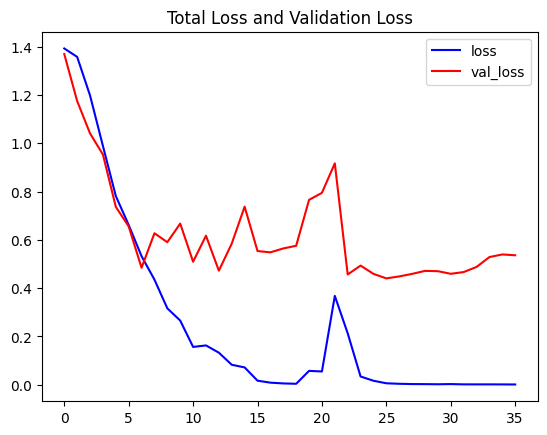

In [21]:
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss and Validation Loss')

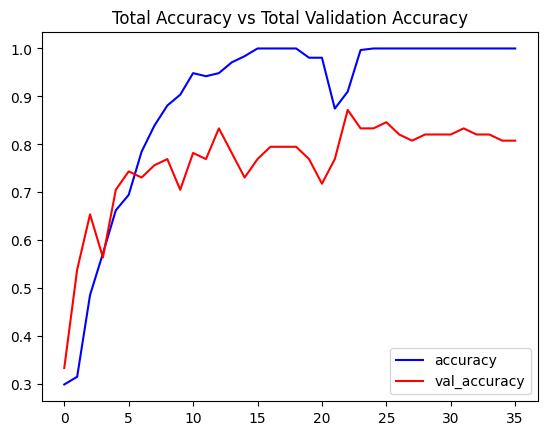

In [23]:
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [24]:
def create_LRCN_model():
    model = Sequential()
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (sequence_length, image_height, image_width, 3)))
    
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
                                      
    model.add(Dense(len(class_list), activation = 'softmax'))

    model.summary()
    return model

In [25]:
LRCN_model = create_LRCN_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDis  (None, 20, 64, 64, 16)   448       
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 20, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 20, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 20, 16, 16, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 20, 4, 4, 32)    

In [26]:
# Early Stopping
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

In [27]:
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

In [28]:
LRCN_model_training_history = LRCN_model.fit(features_train, labels_train, 
                                             epochs = 70, 
                                             batch_size = 4 , 
                                             shuffle = True, 
                                             validation_split = 0.2, 
                                             callbacks = [early_stopping_callback])

Epoch 1/70
78/78 [==============================] - 10s 79ms/step - loss: 1.3862 - accuracy: 0.2830 - val_loss: 1.3759 - val_accuracy: 0.2564
Epoch 2/70
78/78 [==============================] - 5s 61ms/step - loss: 1.3351 - accuracy: 0.3376 - val_loss: 1.3329 - val_accuracy: 0.3846
Epoch 3/70
78/78 [==============================] - 5s 60ms/step - loss: 1.3020 - accuracy: 0.4502 - val_loss: 1.3050 - val_accuracy: 0.3718
Epoch 4/70
78/78 [==============================] - 4s 53ms/step - loss: 1.1931 - accuracy: 0.4727 - val_loss: 1.2395 - val_accuracy: 0.4103
Epoch 5/70
78/78 [==============================] - 4s 54ms/step - loss: 1.0877 - accuracy: 0.5209 - val_loss: 1.0968 - val_accuracy: 0.5385
Epoch 6/70
78/78 [==============================] - 5s 63ms/step - loss: 0.9884 - accuracy: 0.5949 - val_loss: 0.8622 - val_accuracy: 0.6795
Epoch 7/70
78/78 [==============================] - 5s 61ms/step - loss: 0.8397 - accuracy: 0.6624 - val_loss: 1.0159 - val_accuracy: 0.6538
Epoch 8/70
7

In [29]:
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

4/4 [==============================] - 0s 73ms/step - loss: 0.4056 - accuracy: 0.9082


In [32]:
# Get the loss and accuracy
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
 
date_time_format = '%Y%m%d_%H%M%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
    
model_file_name = f'LRCN_model_{current_date_time_string}_Loss_{model_evaluation_loss}_Accuracy_{model_evaluation_accuracy}.h5'
 
# Save the Model.
LRCN_model.save(model_file_name)

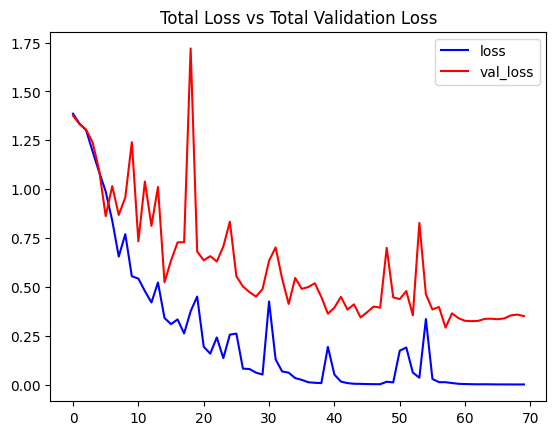

In [33]:
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

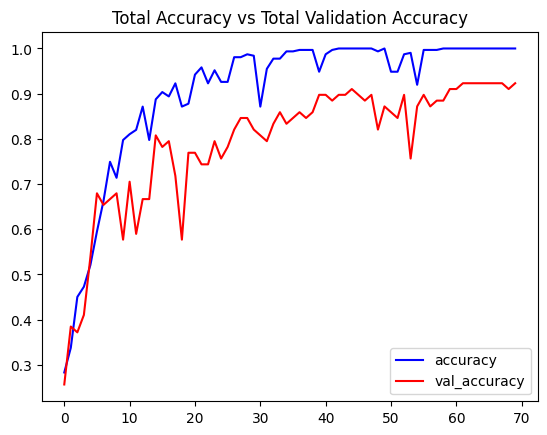

In [34]:
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [35]:
def predict_video(video_path, output_file_path, sequence_length, model):
    video_reader = cv2.VideoCapture(video_path)
    
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'),
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))
    
    frame_queue = deque(maxlen = sequence_length)
    
    predicted_class_name = ''
    
    while video_reader.isOpened():
        success, frame = video_reader.read()
        if not success:
            break
        
        resized_frame = cv2.resize(frame, (image_height, image_width))
        nomalized_frame = resized_frame / 255
        
        frame_queue.append(nomalized_frame)
        
        if len(frame_queue) == sequence_length:
            predicted_labels_probabilities = model.predict(np.expand_dims(frame_queue, axis=0))[0]
            predicted_label = np.argmax(predicted_labels_probabilities)
            predicted_class_name = class_list[predicted_label]
            
        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255), 2)
        video_writer.write(frame)
    
    video_reader.release()
    video_writer.release()

In [36]:
input_video_path = './Test Video.mp4'
output_video_path_1 = './ConvLSTM.mp4'
output_video_path_2 = './LRCN.mp4'

predict_video(input_video_path, output_video_path_1, sequence_length, convlstm_model)
predict_video(input_video_path, output_video_path_2, sequence_length, LRCN_model)

1/1 [==============================] - 0s 25ms/step
